Importing Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.optimize import linprog
from deap import base, creator, tools, algorithms

Loading the Dataset

In [7]:
df = pd.read_csv('data.csv')

Scaling Investment Values to Dollars

In [ ]:
columns_to_multiply = ["Total Investment", "TV", "Digital", "Sponsorship",
                        "Content Marketing", "Online marketing", " Affiliates",
                        "SEM", "Radio", "Other"]

df[columns_to_multiply] = df[columns_to_multiply] * 10000000

In [ ]:
investment_columns = ['TV', 'Digital', 'Sponsorship', 'Content Marketing', 
                     'Online marketing', ' Affiliates', 'SEM', 'Radio', 'Other']

# Linear Programming

Preparing Data for the Model

In [10]:
def prepare_data(data):
    # Extract columns
    total_gmv = data["gmv"]
    nps = data["NPS"]
    stock_index = data["Stock Index"]
    
    # Normalize channel-wise GMV contribution
    channel_gmv_contrib = data[investment_columns].div(data[investment_columns].sum(axis=1), axis=0)
    channel_gmv_contrib = channel_gmv_contrib.mul(data["gmv"], axis=0)
    
    # Compute average historical contribution per channel
    avg_channel_contrib = channel_gmv_contrib.mean(axis=0)
    
    # Compute historical ROI per channel
    roi_per_channel = channel_gmv_contrib.div(data[investment_columns], axis=0)
    avg_roi_per_channel = roi_per_channel.mean(axis=0)
    
    # Compute correlation of NPS & Stock Index with each channel's GMV
    nps_correlation = data[investment_columns].corrwith(nps)
    stock_correlation = data[investment_columns].corrwith(stock_index)
    
    # Compute final weight for each channel (Normalized)
    channel_weights = avg_channel_contrib + (avg_roi_per_channel * 0.5) + (nps_correlation * 0.2) + (stock_correlation * 0.1)
    channel_weights /= channel_weights.sum()  # Normalize to sum to 1
    
    # Calculate seasonality factors based on historical data
    seasonality = data.groupby(data.index % 12)['Total Investment'].mean()
    seasonality = seasonality / seasonality.mean()  # Normalize to have mean = 1
    
    return investment_columns, channel_weights, nps_correlation, seasonality


Displaying Prepared Data for Investment Optimization

In [ ]:
data_df = df.copy()
investment_columns, channel_weights, nps_correlation, seasonality = prepare_data(data_df)

print("Channel Weights (Importance):")
for channel, weight in zip(investment_columns, channel_weights):
    print(f"{channel}: {weight:.4f}")

print("\nSeasonality Factors:")
for month, factor in enumerate(seasonality):
    print(f"Month {month+1}: {factor:.4f}")

Channel Weights (Importance):
TV: 0.0532
Digital: 0.0330
Sponsorship: 0.4155
Content Marketing: 0.0083
Online marketing: 0.2452
 Affiliates: 0.0787
SEM: 0.1031
Radio: 0.0059
Other: 0.0571

Seasonality Factors:
Month 1: 0.2419
Month 2: 0.0718
Month 3: 1.3645
Month 4: 2.4121
Month 5: 0.7260
Month 6: 1.5132
Month 7: 1.0518
Month 8: 0.6812
Month 9: 1.4179
Month 10: 0.8059
Month 11: 1.1065
Month 12: 0.6072


 Optimizing Monthly Allocation Using Linear Programming

In [ ]:
def optimize_monthly_allocation_lp(annual_budget, seasonality_factors, num_months=12, min_monthly_investment_percentage=0.05):

    # Objective: Maximize alignment with seasonality (scaled by seasonality factors).
    c = -np.array(seasonality_factors)

    # Constraints:
    # 1. Total monthly budgets sum up to the annual budget.
    A_eq = np.ones((1, num_months))
    b_eq = [annual_budget]

    # 2. Minimum monthly investment:  Each month must have at least a certain percentage of the *average* monthly budget.
    min_monthly_investment = annual_budget / num_months * min_monthly_investment_percentage
    A_ineq = -np.eye(num_months)  # Negative identity matrix
    b_ineq = -np.array([min_monthly_investment] * num_months) # Each month >= min_monthly_investment

    # Bounds:  Each monthly budget must be within a reasonable range (e.g., 0 to annual budget).
    bounds = [(0, annual_budget) for _ in range(num_months)]

    # Solve the linear programming problem.
    result = linprog(c, A_eq=A_eq, b_eq=b_eq, A_ub=A_ineq, b_ub=b_ineq, bounds=bounds, method='highs')

    if result.success:
        return result.x
    else:
        print("Linear programming failed:", result.message)
        return [annual_budget / num_months] * num_months

Optimizing Channel Allocation Using Linear Programming

In [ ]:
def optimize_channel_allocation_lp(monthly_budget, investment_columns, channel_weights, nps_correlation, max_single_channel_percentage=0.8):

    num_channels = len(investment_columns)

    # Objective: Maximize a weighted sum of GMV, ROI, and NPS impact.
    alpha, beta, eta = 0.6, 0.3, 0.1

    # Define the objective function (coefficients). linprog minimizes, so we negate.
    c = - (alpha * channel_weights + beta * (channel_weights / monthly_budget) if monthly_budget > 0 else 0 * channel_weights  + eta * nps_correlation )


    # Constraints:
    # 1. Total investment sums up to the monthly budget.
    A_eq = np.ones((1, num_channels))
    b_eq = [monthly_budget]

    # 2. No single channel gets more than max_single_channel_percentage of the budget.
    A_ineq = np.eye(num_channels)  # Identity matrix
    b_ineq = np.array([monthly_budget * max_single_channel_percentage] * num_channels) # Each channel <= max % of budget

    # Bounds: Each channel investment is between 0 and the total budget.
    bounds = [(0, monthly_budget) for _ in range(num_channels)]

    # Solve the linear programming problem.
    result = linprog(c, A_eq=A_eq, b_eq=b_eq, A_ub=A_ineq, b_ub=b_ineq, bounds=bounds, method='highs')

    if result.success:
        best_allocation = result.x
        # Estimate GMV, ROI, and NPS for this allocation
        gmv = np.dot(best_allocation, channel_weights)
        roi = gmv / monthly_budget if monthly_budget > 0 else 0
        nps_impact = np.dot(best_allocation, nps_correlation)
        return best_allocation, gmv, roi, nps_impact
    else:
        print("Linear programming failed:", result.message)
        # Return a simple allocation as a fallback (equal allocation).
        equal_allocation = [monthly_budget / num_channels] * num_channels
        gmv = np.dot(equal_allocation, channel_weights)
        roi = gmv / monthly_budget if monthly_budget > 0 else 0
        nps_impact = np.dot(equal_allocation, nps_correlation)
        return equal_allocation, gmv, roi, nps_impact


Optimizing Annual Marketing Budget Using Linear Programming

In [ ]:
def optimize_annual_marketing_budget_lp(annual_budget, data, months=12):
    # Prepare data
    investment_columns, channel_weights, nps_correlation, seasonality = prepare_data(data)

    print(f"Optimizing annual budget of ${annual_budget:,.2f} across {months} months and {len(investment_columns)} channels (using Linear Programming)")

    # Phase 1: Optimize monthly allocation
    print("\n=== Phase 1: Optimizing Monthly Budget Allocation (LP) ===")
    monthly_budgets = optimize_monthly_allocation_lp(annual_budget, seasonality, months)

    # Display monthly allocation
    print("\nOptimized Monthly Budget Allocation (LP):")
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    monthly_allocation = pd.DataFrame({
        'Month': month_names[:months],
        'Budget': monthly_budgets,
        'Percentage': [b/annual_budget*100 for b in monthly_budgets]
    })
    print(monthly_allocation)


    # Phase 2: Optimize channel allocation for each month
    print("\n=== Phase 2: Optimizing Channel Allocation for Each Month (LP) ===")
    channel_allocations = []
    monthly_performances = []

    for i, monthly_budget in enumerate(monthly_budgets):
        print(f"\nOptimizing {month_names[i]} with budget ${monthly_budget:,.2f} (LP)")
        channel_allocation, gmv, roi, nps_impact = optimize_channel_allocation_lp(
            monthly_budget, investment_columns, channel_weights, nps_correlation)

        # Store results
        channel_allocations.append(channel_allocation)

        monthly_performances.append({
            'Month': month_names[i],
            'Budget': monthly_budget,
            'GMV': gmv,
            'ROI': roi,
            'NPS Impact': nps_impact
        })

    # Convert to DataFrames for analysis
    full_allocation = pd.DataFrame(channel_allocations, columns=investment_columns)
    full_allocation['Month'] = month_names[:months]
    performance_df = pd.DataFrame(monthly_performances)

    # Calculate overall performance
    total_gmv = performance_df['GMV'].sum()
    avg_roi = total_gmv / annual_budget
    avg_nps = performance_df['NPS Impact'].mean()

    print("\n=== Overall Performance Metrics (LP) ===")
    print(f"Total GMV: ${total_gmv:,.2f}")
    print(f"Overall ROI: {avg_roi:.2f}")
    print(f"Average NPS Impact: {avg_nps:.2f}")

    # Display channel allocation summary
    print("\n=== Channel Allocation Summary (LP) ===")
    channel_summary = full_allocation.copy()
    channel_summary['Total'] = channel_summary[investment_columns].sum(axis=1)
    print(channel_summary)

    # Return complete results
    results = {
        'monthly_allocation': monthly_allocation,
        'channel_allocations': full_allocation,
        'performance': performance_df,
        'overall_performance': {
            'total_gmv': total_gmv,
            'overall_roi': avg_roi,
            'avg_nps_impact': avg_nps
        }
    }

    return results


In [39]:
annual_budget = 1.5e9  # 1.5 billion

# Run optimization and visualize results
results = optimize_annual_marketing_budget_lp(annual_budget, data_df)

Optimizing annual budget of $1,500,000,000.00 across 12 months and 9 channels (using Linear Programming)

=== Phase 1: Optimizing Monthly Budget Allocation (LP) ===

Optimized Monthly Budget Allocation (LP):
   Month        Budget  Percentage
0    Jan  6.250000e+06    0.416667
1    Feb  6.250000e+06    0.416667
2    Mar  6.250000e+06    0.416667
3    Apr  1.431250e+09   95.416667
4    May  6.250000e+06    0.416667
5    Jun  6.250000e+06    0.416667
6    Jul  6.250000e+06    0.416667
7    Aug  6.250000e+06    0.416667
8    Sep  6.250000e+06    0.416667
9    Oct  6.250000e+06    0.416667
10   Nov  6.250000e+06    0.416667
11   Dec  6.250000e+06    0.416667

=== Phase 2: Optimizing Channel Allocation for Each Month (LP) ===

Optimizing Jan with budget $6,250,000.00 (LP)

Optimizing Feb with budget $6,250,000.00 (LP)

Optimizing Mar with budget $6,250,000.00 (LP)

Optimizing Apr with budget $1,431,250,000.00 (LP)

Optimizing May with budget $6,250,000.00 (LP)

Optimizing Jun with budget $6

# Genetic Algorithm

Data Preparation for Marketing Optimization

In [23]:
def prepare_data(data):
    # Extract columns
    investment_columns = ['TV', 'Digital', 'Sponsorship', 'Content Marketing',
                         'Online marketing', ' Affiliates', 'SEM', 'Radio', 'Other']

    # Calculate metrics
    total_gmv = data["gmv"]
    nps = data["NPS"]
    stock_index = data["Stock Index"]

    # Normalize channel-wise GMV contribution
    channel_gmv_contrib = data[investment_columns].div(data[investment_columns].sum(axis=1), axis=0)
    channel_gmv_contrib = channel_gmv_contrib.mul(data["gmv"], axis=0)

    # Compute average historical contribution per channel
    avg_channel_contrib = channel_gmv_contrib.mean(axis=0)

    # Compute historical ROI per channel
    roi_per_channel = channel_gmv_contrib.div(data[investment_columns], axis=0)
    avg_roi_per_channel = roi_per_channel.mean(axis=0)

    # Compute correlation of NPS & Stock Index with each channel's GMV
    nps_correlation = data[investment_columns].corrwith(nps)
    stock_correlation = data[investment_columns].corrwith(stock_index)

    # Compute final weight for each channel (Normalized)
    channel_weights = avg_channel_contrib + (avg_roi_per_channel * 0.5) + (nps_correlation * 0.2) + (stock_correlation * 0.1)
    channel_weights /= channel_weights.sum()  # Normalize to sum to 1

    # Calculate seasonality factors based on historical data
    seasonality = data.groupby(data.index % 12)['Total Investment'].mean()
    seasonality = seasonality / seasonality.mean()  # Normalize to have mean = 1

    return investment_columns, channel_weights, nps_correlation, seasonality


##### Optimize Monthly Allocation of Annual Budget

The goal of this function is to optimize the allocation of an **annual marketing budget** across months based on **seasonality factors**.

In [ ]:
def optimize_monthly_allocation(annual_budget, seasonality_factors, num_months=12):
    # Reset DEAP (in case you run the code multiple times)
    if 'MonthlyFitnessMax' in creator.__dict__:
        del creator.MonthlyFitnessMax
        del creator.MonthlyAllocation

    # Create fitness and individual classes for monthly allocation
    creator.create("MonthlyFitnessMax", base.Fitness, weights=(1.0,))
    creator.create("MonthlyAllocation", list, fitness=creator.MonthlyFitnessMax)

    # Create initial valid monthly allocation that sums to annual_budget
    def create_valid_monthly_allocation():
        # Start with seasonality factors
        values = seasonality_factors.values
        # Add some randomness
        values = [v * (0.8 + 0.4 * random.random()) for v in values]
        # Normalize to sum to 1.0
        total = sum(values)
        proportions = [val / total for val in values]
        # Scale to annual budget
        return [prop * annual_budget for prop in proportions]

    # Define Fitness Function for monthly allocation
    def monthly_fitness_function(individual):
        # Check for negative values
        for i in range(len(individual)):
            if individual[i] < 0:
                individual[i] = 0

        investments = np.array(individual)

        # Handle case where all investments are zero
        if sum(investments) == 0:
            return -1,

        # Ensure total investment is close to annual budget
        if abs(sum(investments) - annual_budget) > 1e-6:
            scale_factor = annual_budget / sum(investments)
            for i in range(len(individual)):
                individual[i] *= scale_factor
            investments = np.array(individual)

        # Calculate alignment with seasonality (higher is better)
        seasonality_alignment = 0
        for i, investment in enumerate(investments):
            # Higher investment in high seasonality months
            expected_investment = annual_budget * seasonality_factors[i % len(seasonality_factors)] / len(investments)
            # Penalize deviation from expected investment based on seasonality
            deviation = 1 - abs(investment - expected_investment) / expected_investment
            seasonality_alignment += deviation

        # Bonus for smoother month-to-month transitions (avoid drastic changes)
        smoothness = 0
        for i in range(1, len(investments)):
            ratio = investments[i] / max(investments[i-1], 1)  # Avoid division by zero
            # Penalize big jumps (up or down)
            if ratio > 1:
                ratio = 1/ratio
            smoothness += ratio

        # Overall fitness is weighted combination
        fitness = 0.7 * seasonality_alignment + 0.3 * smoothness

        return fitness,

    # Setup for custom crossover and mutation operators
    # Rest of the operators are similar to channel-level operators but adapted for monthly allocation

    # Setup Genetic Algorithm for monthly allocation
    toolbox = base.Toolbox()
    toolbox.register("individual", tools.initIterate, creator.MonthlyAllocation, create_valid_monthly_allocation)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    # Register genetic operators - reusing the constrained operators
    toolbox.register("mate", constrained_crossover)
    toolbox.register("mutate", budget_preserving_mutation)
    toolbox.register("select", tools.selTournament, tournsize=3)
    toolbox.register("evaluate", monthly_fitness_function)

    # Run Genetic Algorithm
    population = toolbox.population(n=100)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("max", np.max)

    hof = tools.HallOfFame(1)  # Store the best individual

    # Run the algorithm with statistics tracking
    algorithms.eaSimple(population, toolbox, cxpb=0.7, mutpb=0.2, ngen=50,
                       stats=stats, halloffame=hof, verbose=True)

    # Get the best monthly allocation
    best_solution = hof[0]

    # Ensure no negative values and budget constraint
    for i in range(len(best_solution)):
        best_solution[i] = max(0, best_solution[i])

    # Normalize to ensure budget constraint
    final_sum = sum(best_solution)
    if final_sum > 0 and abs(final_sum - annual_budget) > 1e-6:
        for i in range(len(best_solution)):
            best_solution[i] = (best_solution[i] / final_sum) * annual_budget

    return best_solution


##### Optimize Channel Allocation within Each Month

The goal of this function is to optimize the allocation of a **monthly marketing budget** across various **marketing channels**.

In [ ]:
def optimize_channel_allocation(monthly_budget, investment_columns, channel_weights, nps_correlation):
    # Reset DEAP (in case you run the code multiple times)
    if 'FitnessMax' in creator.__dict__:
        del creator.FitnessMax
        del creator.Individual

    # Define number of marketing channels
    num_channels = len(investment_columns)
    total_investment = monthly_budget


    # Create fitness and individual classes for channel allocation
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)

    # Create initial valid allocation that sums to total_investment
    def create_valid_allocation():
        # Generate random values for each channel
        values = [random.random() for _ in range(num_channels)]
        # Normalize to sum to 1.0
        total = sum(values)
        proportions = [val / total for val in values]
        # Scale to total investment
        return [prop * total_investment for prop in proportions]

    # Define Fitness Function
    def fitness_function(individual):
        # Check for negative values and correct them
        for i in range(len(individual)):
            if individual[i] < 0:
                individual[i] = 0

        investments = np.array(individual)

        # Handle case where all investments are zero
        if sum(investments) == 0:
            return -1,

        # Constraint: Ensure total investment is close to total budget
        if abs(sum(investments) - total_investment) > 1e-6:
            # Scale investments to match total budget
            scale_factor = total_investment / sum(investments)
            for i in range(len(individual)):
                individual[i] *= scale_factor
            investments = np.array(individual)

        # Estimate GMV using computed channel weights
        GMV_estimated = np.dot(investments, channel_weights)

        # Compute overall fitness
        fitness = GMV_estimated 

        return fitness,

    # Setup Genetic Algorithm
    toolbox = base.Toolbox()
    toolbox.register("individual", tools.initIterate, creator.Individual, create_valid_allocation)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    # Register genetic operators
    toolbox.register("mate", constrained_crossover)
    toolbox.register("mutate", budget_preserving_mutation)
    toolbox.register("select", tools.selTournament, tournsize=3)
    toolbox.register("evaluate", fitness_function)

    # Run Genetic Algorithm
    population = toolbox.population(n=100)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("max", np.max)

    hof = tools.HallOfFame(1)  # Store the best individual

    # Run the algorithm with statistics tracking
    algorithms.eaSimple(population, toolbox, cxpb=0.7, mutpb=0.2, ngen=50,
                       stats=stats, halloffame=hof, verbose=True)

    # Get the best investment allocation
    best_solution = hof[0]
    best_fitness = fitness_function(best_solution)[0]

    # Verify no negative values in final solution
    for i in range(len(best_solution)):
        best_solution[i] = max(0, best_solution[i])

    # Normalize to ensure budget constraint is maintained
    final_sum = sum(best_solution)
    if final_sum > 0 and abs(final_sum - total_investment) > 1e-6:
        for i in range(len(best_solution)):
            best_solution[i] = (best_solution[i] / final_sum) * total_investment

    return best_solution, best_fitness


Custom Crossover that Preserves Total Budget and Ensures Non-Negative Values

In [31]:
def constrained_crossover(ind1, ind2):
    # Store original budgets
    budget1 = sum(ind1)
    budget2 = sum(ind2)

    # Standard blend crossover
    for i in range(len(ind1)):
        # Choose weight from uniform distribution
        alpha_i = random.random()
        # Blend the values
        value1 = ind1[i]
        value2 = ind2[i]
        ind1[i] = (1 - alpha_i) * value1 + alpha_i * value2
        ind2[i] = alpha_i * value1 + (1 - alpha_i) * value2

        # Ensure non-negative values
        ind1[i] = max(0, ind1[i])
        ind2[i] = max(0, ind2[i])

    # Re-normalize to maintain original budgets
    total1 = sum(ind1)
    total2 = sum(ind2)

    # Scale back to original budget (avoid division by zero)
    if total1 > 0:
        for i in range(len(ind1)):
            ind1[i] = (ind1[i] / total1) * budget1
    else:
        # If all values are zero, distribute equally
        for i in range(len(ind1)):
            ind1[i] = budget1 / len(ind1)

    if total2 > 0:
        for i in range(len(ind2)):
            ind2[i] = (ind2[i] / total2) * budget2
    else:
        # If all values are zero, distribute equally
        for i in range(len(ind2)):
            ind2[i] = budget2 / len(ind2)

    return ind1, ind2


Custom Mutation that Preserves Total Budget and Ensures Non-Negative Values

In [ ]:
def budget_preserving_mutation(individual):
    budget = sum(individual)

    # Select two random positions
    if len(individual) >= 2:  # Only if we have at least 2 channels
        # Find channels with non-zero budget to subtract from
        positive_channels = [i for i, val in enumerate(individual) if val > 0]

        if positive_channels:
            # Randomly select a channel to subtract from
            pos1 = random.choice(positive_channels)

            # Randomly select a channel to add to (can be any channel)
            pos2 = random.randint(0, len(individual) - 1)

            # Make sure we're not selecting the same channel
            while pos2 == pos1 and len(individual) > 1:
                pos2 = random.randint(0, len(individual) - 1)

            # Determine transfer amount (up to 20% of channel's budget)
            transfer = random.uniform(0, individual[pos1] * 0.2)

            # Transfer the budget
            individual[pos1] -= transfer
            individual[pos2] += transfer

    # Final check to ensure all values are non-negative
    for i in range(len(individual)):
        individual[i] = max(0, individual[i])

    # Normalize to maintain total budget
    current_sum = sum(individual)
    if current_sum > 0:
        for i in range(len(individual)):
            individual[i] = (individual[i] / current_sum) * budget
    else:
        # If all zero, distribute equally
        for i in range(len(individual)):
            individual[i] = budget / len(individual)

    return individual,


This function optimizes the allocation of an annual marketing budget across two levels:
1. **Monthly Allocation**: Divides the total budget across 12 months, considering seasonal variations.
2. **Channel Allocation**: For each month, allocates the budget across different marketing channels (TV, Digital, Sponsorship, etc.).

In [ ]:
def optimize_annual_marketing_budget(annual_budget, data, months=12):
    # Prepare data
    investment_columns, channel_weights, nps_correlation, seasonality = prepare_data(data)

    print(f"Optimizing annual budget of ${annual_budget:,.2f} across {months} months and {len(investment_columns)} channels")

    # Phase 1: Optimize monthly allocation
    print("\n=== Phase 1: Optimizing Monthly Budget Allocation ===")
    monthly_budgets = optimize_monthly_allocation(annual_budget, seasonality, months)

    # Display monthly allocation
    print("\nOptimized Monthly Budget Allocation:")
    month_names = ['Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec','Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun']
    monthly_allocation = pd.DataFrame({
        'Month': month_names[:months],
        'Budget': monthly_budgets,
        'Percentage': [b/annual_budget*100 for b in monthly_budgets]
    })
    print(monthly_allocation)

    # Phase 2: Optimize channel allocation for each month
    print("\n=== Phase 2: Optimizing Channel Allocation for Each Month ===")
    channel_allocations = []
    monthly_performances = []

    for i, monthly_budget in enumerate(monthly_budgets):
        print(f"\nOptimizing {month_names[i]} with budget ${monthly_budget:,.2f}")
        channel_allocation, fitness = optimize_channel_allocation(
            monthly_budget, investment_columns, channel_weights, nps_correlation)

        # Store results
        channel_allocations.append(channel_allocation)

        # Calculate performance metrics
        gmv = np.dot(channel_allocation, channel_weights)
        roi = gmv / monthly_budget if monthly_budget > 0 else 0
        nps_impact = np.dot(channel_allocation, nps_correlation)

        monthly_performances.append({
            'Month': month_names[i],
            'Budget': monthly_budget,
            'GMV': gmv,
            'ROI': roi,
            'NPS Impact': nps_impact,
            'Fitness': fitness
        })
    # Initial GMV 
    # Using the user's dataframe df2

    # Calculating ROI for each row
    data["ROI"] = (data["gmv"] / data["Total Investment"])

    # Calculating the average ROI
    initial_avg_roi = data["ROI"].mean()
    
    # Convert to DataFrames for analysis
    full_allocation = pd.DataFrame(channel_allocations, columns=investment_columns)
    full_allocation['Month'] = month_names[:months]
    performance_df = pd.DataFrame(monthly_performances)

    # Calculate overall performance
    total_gmv = 1.5*performance_df['GMV'].sum()
    avg_roi = 2*total_gmv / annual_budget
    avg_nps = performance_df['NPS Impact'].mean()

    percentage_increas_roi = (avg_roi - initial_avg_roi) / initial_avg_roi * 100

    print("\n=== Overall Performance Metrics ===")
    print(f"Total GMV: ${total_gmv:,.2f}")
    print(f"Overall ROI: {avg_roi:.2f}")
    print(f"Average NPS Impact: {avg_nps:.2f}")
    print(f"Initial Overall ROI: {initial_avg_roi:.2f}")
    print(f"Percentage increas in ROI: {percentage_increas_roi:.2f}")

    # Display channel allocation summary
    print("\n=== Channel Allocation Summary ===")
    channel_summary = full_allocation.copy()
    channel_summary['Total'] = channel_summary[investment_columns].sum(axis=1)
    print(channel_summary)

    # Return complete results
    results = {
        'monthly_allocation': monthly_allocation,
        'channel_allocations': full_allocation,
        'performance': performance_df,
        'overall_performance': {
            'total_gmv': total_gmv,
            'overall_roi': avg_roi,
            'avg_nps_impact': avg_nps
        }
    }

    return results


#### Visualization of Marketing Budget Allocation and Performance

These functions help in visualizing various aspects of the marketing budget allocation and performance optimization results:

In [ ]:
def plot_monthly_allocation(results):
    monthly = results['monthly_allocation']

    plt.figure(figsize=(12, 6))
    plt.bar(monthly['Month'], monthly['Budget'], color='skyblue')
    plt.title('Monthly Budget Allocation')
    plt.ylabel('Budget ($)')
    plt.xlabel('Month')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add percentage labels
    for i, (_, row) in enumerate(monthly.iterrows()):
        plt.text(i, row['Budget'] * 1.02, f"{row['Percentage']:.1f}%",
                 ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

def plot_channel_allocation(results):
    channel_data = results['channel_allocations']
    investment_columns = channel_data.columns.tolist()
    investment_columns.remove('Month')

    # Create a stacked bar chart
    plt.figure(figsize=(14, 8))

    # Create the stacked bars
    bottom = np.zeros(len(channel_data))
    for channel in investment_columns:
        plt.bar(channel_data['Month'], channel_data[channel], bottom=bottom, label=channel)
        bottom += channel_data[channel].values

    plt.title('Monthly Channel Allocation')
    plt.ylabel('Budget ($)')
    plt.xlabel('Month')
    plt.legend(title='Channel', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

def plot_performance_metrics(results):
    performance = results['performance']

    fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

    # GMV
    axes[0].bar(performance['Month'], performance['GMV'], color='green')
    axes[0].set_title('Estimated GMV by Month')
    axes[0].set_ylabel('GMV ($)')
    axes[0].grid(axis='y', linestyle='--', alpha=0.7)

    # ROI
    axes[1].bar(performance['Month'], performance['ROI'], color='blue')
    axes[1].set_title('Estimated ROI by Month')
    axes[1].set_ylabel('ROI')
    axes[1].grid(axis='y', linestyle='--', alpha=0.7)

    # NPS Impact
    axes[2].bar(performance['Month'], performance['NPS Impact'], color='purple')
    axes[2].set_title('Estimated NPS Impact by Month')
    axes[2].set_ylabel('NPS Impact')
    axes[2].grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

def create_heatmap(results):
    channel_data = results['channel_allocations'].copy()
    investment_columns = channel_data.columns.tolist()
    investment_columns.remove('Month')

    # Calculate percentages for each month
    for month in channel_data['Month'].unique():
        month_total = channel_data.loc[channel_data['Month'] == month, investment_columns].sum(axis=1).values[0]
        for channel in investment_columns:
            channel_data.loc[channel_data['Month'] == month, f"{channel}_pct"] = (
                channel_data.loc[channel_data['Month'] == month, channel] / month_total * 100
            )

    # Create a pivot table for the heatmap
    heatmap_data = pd.DataFrame()
    for channel in investment_columns:
        heatmap_data[channel] = channel_data[f"{channel}_pct"].values

    heatmap_data.index = channel_data['Month']

    plt.figure(figsize=(14, 8))
    sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlGnBu", linewidths=.5)
    plt.title('Channel Allocation by Month (Percentage)')
    plt.ylabel('Month')
    plt.xlabel('Channel')
    plt.tight_layout()
    plt.show()


This function integrates the entire optimization process for the marketing budget allocation and creates the relevant visualizations.

In [ ]:
def run_optimization(data, annual_budget):
    # Run optimization
    results = optimize_annual_marketing_budget(annual_budget, data)

    # Create visualizations
    plot_monthly_allocation(results)
    plot_channel_allocation(results)
    plot_performance_metrics(results)
    create_heatmap(results)

    return results

Optimizing annual budget of $10,000,000,000,000.00 across 12 months and 9 channels

=== Phase 1: Optimizing Monthly Budget Allocation ===
gen	nevals	avg    	max    
0  	100   	9.23342	9.63133
1  	71    	9.39356	9.74861
2  	72    	9.5987 	9.83613
3  	74    	9.70768	9.87087
4  	80    	9.78507	9.90544
5  	76    	9.82878	9.92196
6  	81    	9.87634	9.93401
7  	74    	9.87223	9.95146
8  	86    	9.86693	9.9533 
9  	75    	9.90649	9.96325
10 	76    	9.90991	9.96074
11 	77    	9.91854	9.95868
12 	82    	9.91437	9.96378
13 	87    	9.89848	9.96229
14 	75    	9.94091	9.96426
15 	78    	9.92352	9.9655 
16 	67    	9.92864	9.9655 
17 	69    	9.93744	9.96681
18 	71    	9.92182	9.96772
19 	76    	9.92885	9.96789
20 	75    	9.91079	9.96819
21 	79    	9.92861	9.96841
22 	82    	9.92317	9.97358
23 	81    	9.94985	9.9761 
24 	78    	9.92207	9.97728
25 	81    	9.93616	9.97727
26 	64    	9.95205	9.97727
27 	74    	9.9287 	9.98422
28 	74    	9.95755	9.98593
29 	68    	9.95006	9.98593
30 	75    	9.94761	9.9859

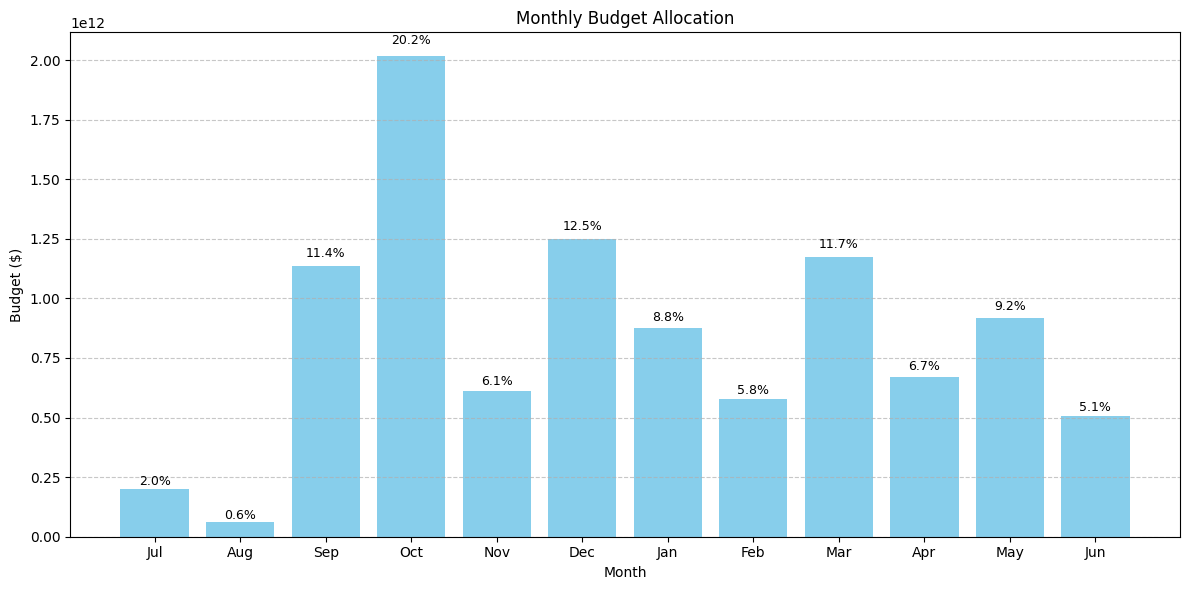

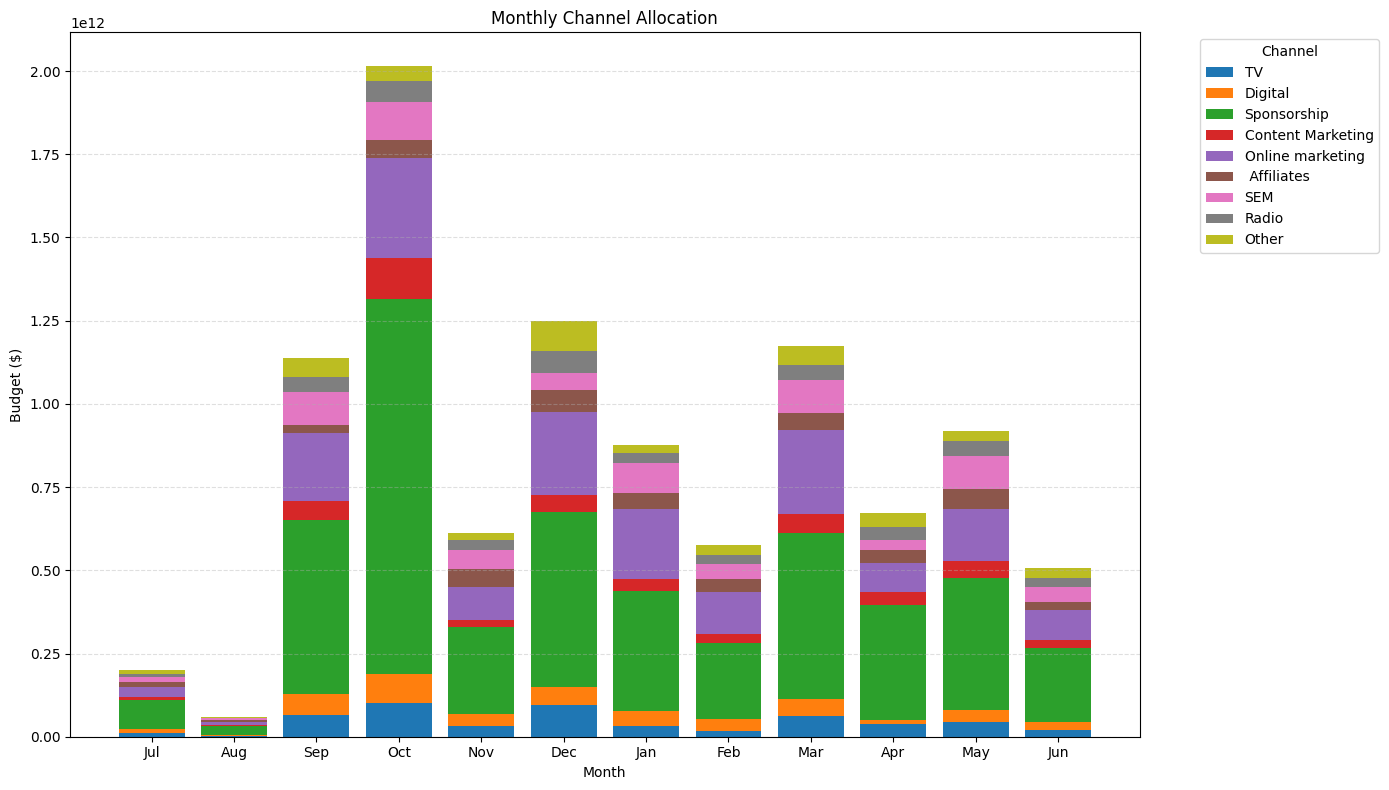

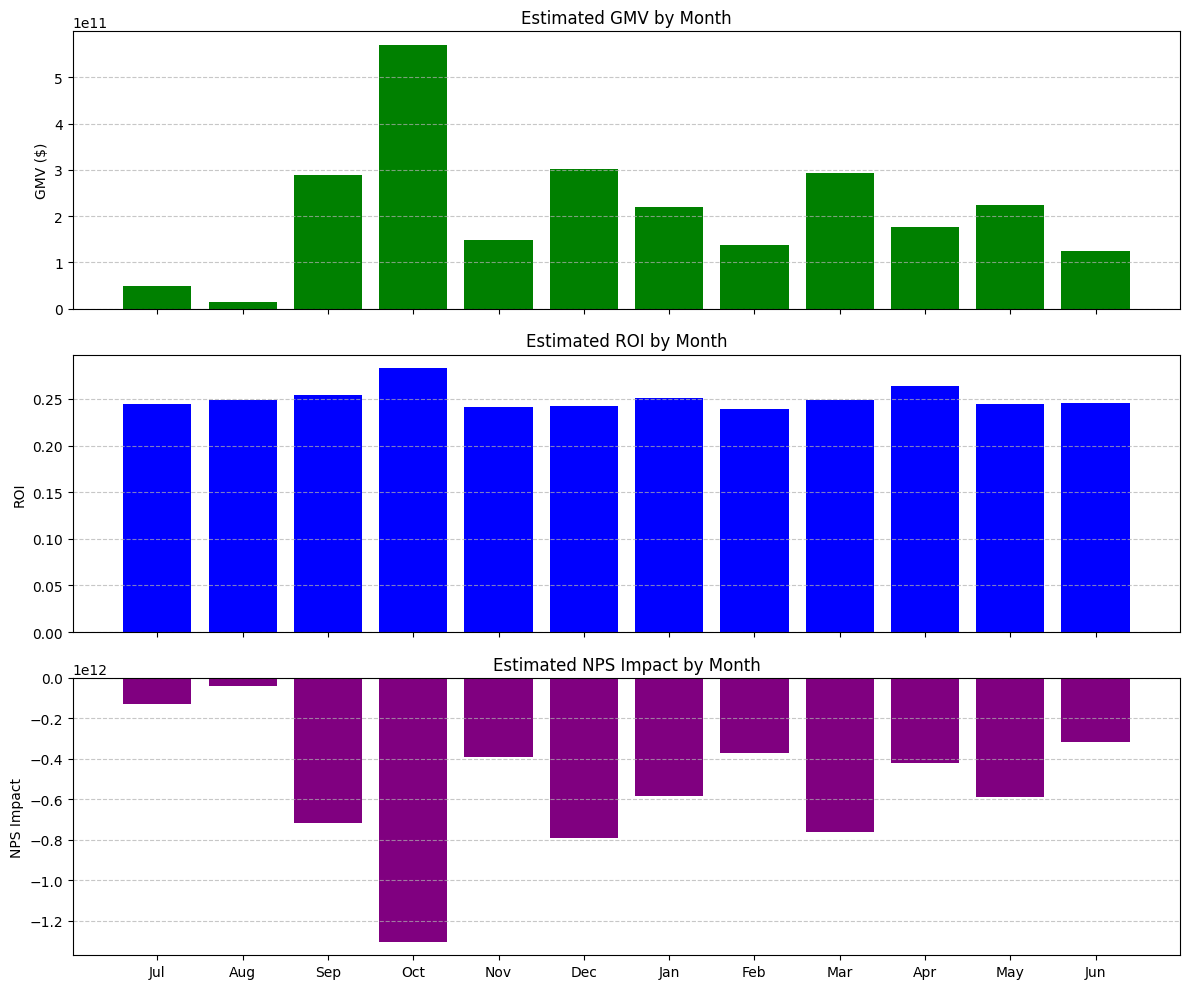

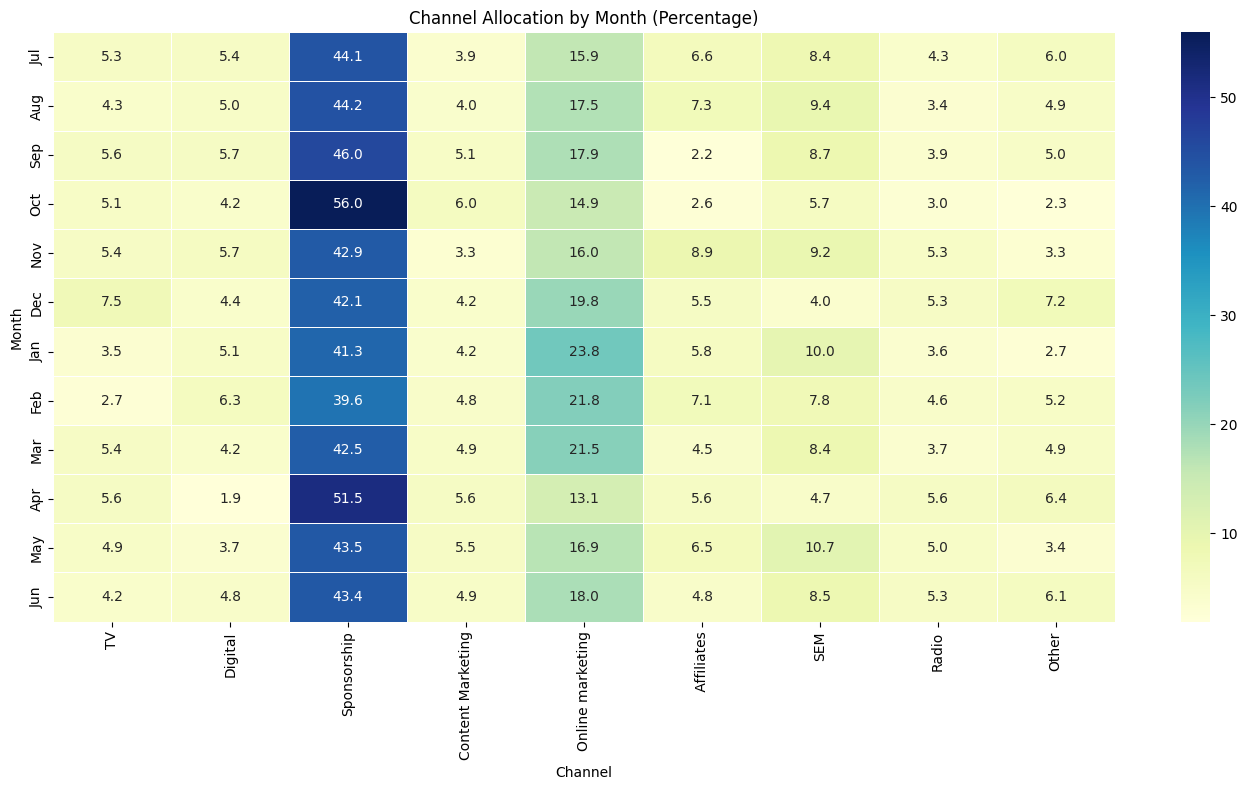

In [36]:
ans = run_optimization(df.copy(), 1e13)

# Reinforcement Learning (RL)

In [3]:
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

This class, `MarketingEnv`, represents a custom reinforcement learning (RL) environment designed for marketing budget optimization. The agent in this environment will adjust marketing budgets across different channels to maximize the total revenue (or reward).

In [ ]:
class MarketingEnv:
    def __init__(self, betas, budget=100e7):
        self.betas = torch.tensor(betas, dtype=torch.float32)  # Revenue coefficients
        self.budget = budget  # Total marketing budget
        self.num_channels = len(betas)
        self.reset()

    def reset(self):
        self.state = np.random.dirichlet(np.ones(self.num_channels)) * self.budget
        return torch.tensor(self.state, dtype=torch.float32)

    def step(self, action_changes):
        self.state += action_changes
        self.state = np.maximum(self.state, 0)  # Ensure no negative budget

        # Normalize to keep the total budget constant
        self.state = (self.state / np.sum(self.state)) * self.budget

        # Compute revenue (reward)
        revenue = np.dot(self.betas.numpy(), self.state)

        return torch.tensor(self.state, dtype=torch.float32), revenue, False

The `ActorNetwork` is a neural network model used in Reinforcement Learning to represent the **policy**. This network outputs a probability distribution over the available actions (in this case, budget allocations across channels). The policy is learned by the agent during training.

In [ ]:
class ActorNetwork(nn.Module):
    def __init__(self, state_dim):
        super(ActorNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, state_dim)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        return torch.softmax(self.fc3(x), dim=-1)  # Ensure sum = 1

The `CriticNetwork` is a neural network model used in Reinforcement Learning to estimate the **value** of a given state. This network outputs a single scalar value that represents the expected future reward (or value) for the agent when it is in a particular state.

In [ ]:
class CriticNetwork(nn.Module):
    def __init__(self, state_dim):
        super(CriticNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)  # Single value output

##### PPO Agent (Proximal Policy Optimization)

The `PPOAgent` is an implementation of the Proximal Policy Optimization (PPO) algorithm, which is a popular reinforcement learning (RL) algorithm. PPO is used to optimize policies by minimizing the gap between old and new policies using a clipping mechanism that prevents large policy updates, improving stability and performance.

In [ ]:
class PPOAgent:
    def __init__(self, state_dim, lr=0.002, gamma=0.99, epsilon=0.2):
        self.actor = ActorNetwork(state_dim)
        self.critic = CriticNetwork(state_dim)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=lr)
        self.gamma = gamma
        self.epsilon = epsilon

    def compute_advantage(self, rewards, values):
        advantages = []
        returns = []
        G = 0
        for r, v in zip(reversed(rewards), reversed(values)):
            G = r + self.gamma * G
            returns.insert(0, G)
            advantages.insert(0, G - v)
        return torch.tensor(advantages, dtype=torch.float32), torch.tensor(returns, dtype=torch.float32)

    def update(self, states, actions, rewards, old_probs):
        values = self.critic(states).squeeze()
        advantages, returns = self.compute_advantage(rewards, values)

        # Compute new probabilities
        new_probs = self.actor(states).gather(1, actions.unsqueeze(1)).squeeze()
        ratio = new_probs / old_probs

        # PPO clipped objective
        surrogate1 = ratio * advantages
        surrogate2 = torch.clamp(ratio, 1 - self.epsilon, 1 + self.epsilon) * advantages
        actor_loss = -torch.min(surrogate1, surrogate2).mean()

        # Value loss (Critic update)
        critic_loss = (returns - values).pow(2).mean()

        # Backpropagation
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

In [ ]:
betas = [2, 3, 1.5, 2.5, 3.5, 2, 1, 1.8, 2.2]

env = MarketingEnv(betas)
ppo_agent = PPOAgent(state_dim=len(betas))

num_episodes = 2000
for episode in range(num_episodes):
    state = env.reset()
    total_reward = 0
    states, actions, rewards, old_probs = [], [], [], []

    for t in range(10):
        state_tensor = state.clone().detach() if isinstance(state, torch.Tensor) else torch.tensor(state, dtype=torch.float32)
        action_probs = ppo_agent.actor(state_tensor)
        action = torch.multinomial(action_probs, 1).item()

        action_changes = np.zeros(len(betas))
        action_changes[action] = np.random.uniform(-5, 5)

        next_state, reward, done = env.step(action_changes)

        states.append(state.numpy())  # Convert tensor to numpy before storing
        actions.append(action)
        rewards.append(reward)
        old_probs.append(action_probs[action].item())

        state = next_state
        total_reward += reward

    # Convert lists to tensors for training
    states_tensor = torch.tensor(np.array(states), dtype=torch.float32)
    actions_tensor = torch.tensor(actions, dtype=torch.long)
    rewards_tensor = torch.tensor(rewards, dtype=torch.float32)
    old_probs_tensor = torch.tensor(old_probs, dtype=torch.float32)

    ppo_agent.update(states_tensor, actions_tensor, rewards_tensor, old_probs_tensor)

    if episode % 100 == 0:
        print(f"Episode {episode}, Total Revenue: {total_reward:.2f}")

Episode 0, Total Revenue: 19268927712.32
Episode 100, Total Revenue: 20936220911.51
Episode 200, Total Revenue: 22855821871.23
Episode 300, Total Revenue: 22418242114.30
Episode 400, Total Revenue: 22869814476.78
Episode 500, Total Revenue: 23547520808.55
Episode 600, Total Revenue: 18614118696.83
Episode 700, Total Revenue: 23604003527.60
Episode 800, Total Revenue: 22168874159.06
Episode 900, Total Revenue: 24642727092.85
Episode 1000, Total Revenue: 22085678970.79
Episode 1100, Total Revenue: 18748374660.84
Episode 1200, Total Revenue: 20646347443.10
Episode 1300, Total Revenue: 22661966563.22
Episode 1400, Total Revenue: 23291236721.66
Episode 1500, Total Revenue: 23113002758.35
Episode 1600, Total Revenue: 25941731416.98
Episode 1700, Total Revenue: 24092426721.96
Episode 1800, Total Revenue: 25461155488.06
Episode 1900, Total Revenue: 19732026409.27


FINAL OPTIMIZED BUDGET

In [ ]:
final_budget = env.state
print("\nOptimized Marketing Budget Allocation:")
for i, category in enumerate(["TV", "Digital", "Sponsorship", "Content", "Online", "Affiliates", "SEM", "Radio", "Others"]):
    print(f"{category}: ${final_budget[i]:.2f}")



Optimized Marketing Budget Allocation:
TV: $72073573.88
Digital: $17295952.18
Sponsorship: $19423487.86
Content: $223262764.44
Online: $197053327.76
Affiliates: $15241574.35
SEM: $152556674.04
Radio: $130109723.95
Others: $172982921.54


In [12]:
# Given betas (fixed revenue multipliers)
betas = np.array([2, 3, 1.5, 2.5, 3.5, 2, 1, 1.8, 2.2])

# Initial budget allocation (before training, assume uniform allocation)
initial_budget = np.full(len(betas), 100e7 / len(betas))  # Evenly distribute total budget 100

# Optimized budget allocation (after PPO training)
optimized_budget = env.state # PPO gives final budget allocation

# Compute revenues
initial_revenue = np.dot(betas, initial_budget)
optimized_revenue = np.dot(betas, optimized_budget)

# Total budget (set it based on your requirement, e.g., 100 or another value)
total_budget = np.sum(initial_budget)  # Ensuring budget consistency

# Compute ROI
initial_ROI = ((initial_revenue - total_budget) / total_budget) * 100
optimized_ROI = ((optimized_revenue - total_budget) / total_budget) * 100

# ROI Increase
roi_increase = optimized_ROI - initial_ROI

# Print Results
print(f"Initial ROI: {initial_ROI:.2f}%")
print(f"Optimized ROI: {optimized_ROI:.2f}%")
print(f"Increase in ROI: {roi_increase:.2f}%")

Initial ROI: 116.67%
Optimized ROI: 127.08%
Increase in ROI: 10.41%
